In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wittgenstein as lw
import os

from sklearn.model_selection import train_test_split

from ripper_lut_net import *

In [2]:
data_dir = "data/100_bit_artificial"
dataset_file_path = os.path.join(data_dir, "1a.csv")

dataset_df = pd.read_csv(dataset_file_path)
print(f"Dataset size: {dataset_df.shape}")
dataset_df.head(3)

Dataset size: (10000, 101)


,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a92,a93,a94,a95,a96,a97,a98,a99,a100,class
0,False,True,False,True,True,False,True,False,False,True,...,True,False,False,True,True,True,True,True,True,False
1,True,True,False,False,False,False,False,True,False,True,...,False,True,True,False,True,False,True,True,False,True
2,True,False,True,True,True,True,False,True,True,True,...,False,True,False,False,True,False,True,True,False,True


In [3]:
X = dataset_df.drop(columns=["class"]).values
y = dataset_df["class"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
y.sum() / len(y)

0.5756

In [5]:
%%time

# testing vanilla RIPPER on full dataset

vanilla_ripper = lw.RIPPER()
vanilla_ripper.fit(X_train, y_train)
vanilla_ripper_preds = vanilla_ripper.predict(X_test)
print(f"Accuracy on test set: {accuracy_score(vanilla_ripper_preds, y_test):.2f}")

Accuracy on test set: 0.99
CPU times: user 4.27 s, sys: 47.1 ms, total: 4.32 s
Wall time: 4.35 s


In [6]:
vanilla_ripper.ruleset_

<Ruleset [[16=False^4=True^15=False] V [0=False^4=False^18=True] V [16=False^4=True^87=False] V [0=False^4=False^87=False] V [16=False^4=True^18=True] V [16=False^0=False^62=False] V [37=False^59=True^57=True^62=False] V [4=False^0=False^15=False] V [4=False^71=False^93=True^19=True^62=False] V [57=True^37=False^59=True^15=False] V [15=True^16=False^4=True^62=False] V [15=True^62=True^57=True^37=False^59=True^18=True] V [4=False^0=False^62=False] V [62=True^4=False^71=False^93=True^19=True^0=True^94=False] V [62=True^18=False^15=True^38=False^82=True^0=False^4=False] V [62=True^16=False^4=True^38=False^82=True] V [11=True^26=True^77=True^20=True^82=False] V [62=True^4=False^71=False^19=True^93=True^87=False] V [62=True^18=False^57=True^59=True^37=False^87=False] V [87=True^62=True^4=False^0=False^46=False^43=True^60=False] V [87=True^62=True^36=True^53=True^10=False^16=False^4=True] V [4=False^87=True^62=True^93=True^71=False^19=True^39=True] V [18=False^57=True^37=False^59=True^63=Fal

In [7]:
import re

x = set()
for rule in vanilla_ripper.ruleset_:
    rule_string = str(rule)
    
    indices = re.findall(r'\d+', rule_string)
    
    for index in indices:
        x.add(index)
    
print(x)
    
len(x)
    
    

{'10', '63', '57', '53', '11', '43', '12', '26', '46', '15', '18', '94', '37', '87', '62', '59', '71', '0', '39', '60', '20', '4', '16', '93', '77', '19', '82', '38', '36'}


29

In [8]:
%%time

# test it with a tiny network using the lut

lut_bits = 10
num_layers = 3
num_luts = 16

ripper_net = RipperLut(bits=[lut_bits] * (num_layers + 1), hidden_layers=[num_luts] * num_layers, verbose=True, mode='lut')
preds_train = ripper_net.train(X_train, y_train)
preds_test = ripper_net.predict(X_test)
print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}")

100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


Accuracy on training set: 0.88
Accuracy on test set: 0.54
CPU times: user 527 ms, sys: 1.52 s, total: 2.05 s
Wall time: 15.8 s


In [9]:
%%time

# test it with a tiny network using the lut

lut_bits = 10
num_layers = 3
num_luts = 16

ripper_net = RipperLut(bits=[lut_bits] * (num_layers + 1), hidden_layers=[num_luts] * num_layers, verbose=True, mode='ripper')
preds_train = ripper_net.train(X_train, y_train)
preds_test = ripper_net.predict(X_test)
print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}")

100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


Accuracy on training set: 0.75
Accuracy on test set: 0.75
CPU times: user 1 s, sys: 1.55 s, total: 2.55 s
Wall time: 26.9 s


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


Text(0, 0.5, 'Accuracy')

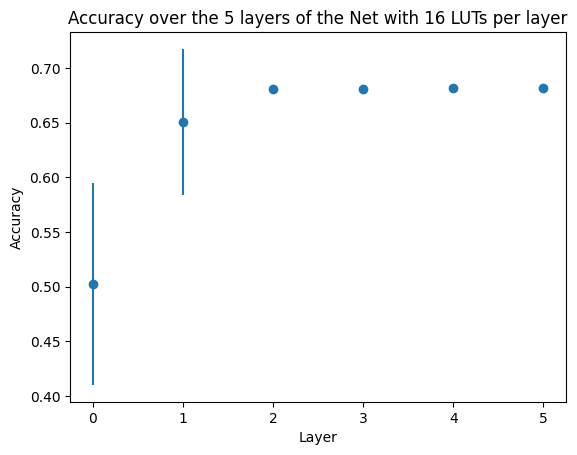

In [10]:
# experiment: accuracies over depth

num_layers = 5
num_layer_luts = 16
nums_lut_bits = 10

ripper_net = RipperLut(bits=[nums_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=True, mode='ripper')
preds_train = ripper_net.train(X_train, y_train)
preds, accs = ripper_net.get_accuracies_per_layer(X_train, y_train)

mean_accs = [np.mean(acc) for acc in accs]
std_accs = [np.std(acc) for acc in accs]

# plot over layers with std
plt.errorbar(range(num_layers + 1), mean_accs, yerr=std_accs, fmt='o')
plt.title(f"Accuracy over the 5 layers of the Net with {num_layer_luts} LUTs per layer")
plt.xlabel("Layer")
plt.ylabel("Accuracy")

2 LUTs per layer: Accuracy on training set: 0.63
2 LUTs per layer: Accuracy on test set: 0.64
4 LUTs per layer: Accuracy on training set: 0.49
4 LUTs per layer: Accuracy on test set: 0.47
8 LUTs per layer: Accuracy on training set: 0.78
8 LUTs per layer: Accuracy on test set: 0.77
16 LUTs per layer: Accuracy on training set: 0.68
16 LUTs per layer: Accuracy on test set: 0.67


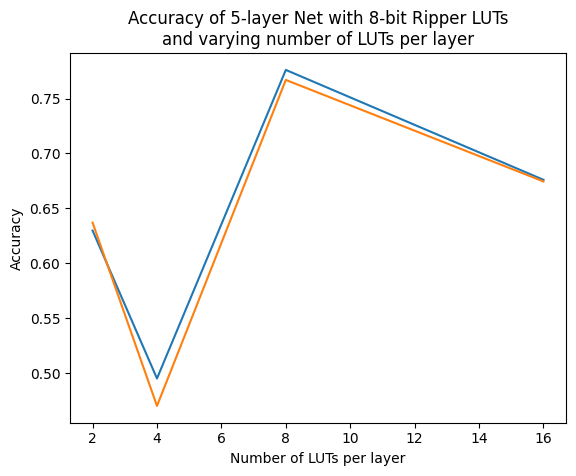

In [11]:
# experiment: accuracies with changing number of LUTs per hidden layer

num_layers = 3
nums_layer_luts = [2, 4, 8, 16] #, 128, 256, 512, 1024, 2048, 4096]
nums_lut_bits = 10

train_accuracies = []
test_accuracies = []
for num_layer_luts in nums_layer_luts:
    ripper_net = RipperLut(bits=[nums_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=False, mode='ripper')

    preds_train = ripper_net.train(X_train, y_train)
    preds_test = ripper_net.predict(X_test)

    train_accuracy = accuracy_score(preds_train, y_train)
    test_accuracy = accuracy_score(preds_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"{num_layer_luts} LUTs per layer: Accuracy on training set: {train_accuracy:.2f}")
    print(f"{num_layer_luts} LUTs per layer: Accuracy on test set: {test_accuracy:.2f}")
    

plt.plot(nums_layer_luts, train_accuracies, label="Train")
plt.plot(nums_layer_luts, test_accuracies, label="Test")
plt.title("Accuracy of 5-layer Net with 8-bit Ripper LUTs\nand varying number of LUTs per layer")
plt.xlabel("Number of LUTs per layer")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# experiment: accuracies with changing number of input bits per LUT

num_layers = 3
num_layer_luts = 8
nums_lut_bits = [2, 4, 8, 16, 32, 64]

train_accuracies = []
test_accuracies = []
for num_lut_bits in nums_lut_bits:
    ripper_net = RipperLut(bits=[num_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=False, mode='ripper')

    preds_train = ripper_net.train(X_train, y_train)
    preds_test = ripper_net.predict(X_test)

    train_accuracy = accuracy_score(preds_train, y_train)
    test_accuracy = accuracy_score(preds_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"{num_lut_bits} bits per LUT: Accuracy on training set: {train_accuracy:.2f}")
    print(f"{num_lut_bits} bits per LUT: Accuracy on test set: {test_accuracy:.2f}")
    
    
plt.plot(nums_lut_bits, train_accuracies, label="Train")
plt.plot(nums_lut_bits, test_accuracies, label="Test")
plt.title("Accuracy of 5-layer Net with 1024 Ripper LUTs per layer\nand varying number of input bits per LUT")
plt.xlabel("Number of input bits per LUT")
plt.ylabel("Accuracy")
plt.show()

2 bits per LUT: Accuracy on training set: 0.51
2 bits per LUT: Accuracy on test set: 0.52
4 bits per LUT: Accuracy on training set: 0.71
4 bits per LUT: Accuracy on test set: 0.70
8 bits per LUT: Accuracy on training set: 0.55
8 bits per LUT: Accuracy on test set: 0.56
